# Binocular dDPI eye-tracker reprocessing: ALL BINOCULAR DATA

In [1]:
import sys
import os
import h5py 

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

if myhost=='it':
    sys.path.insert(0, '/home/felixbartsch/Code/') 
    datadir = '/home/felixbartsch/Data/Conway/'  
    dirname = '/home/felixbartsch/Data/Colorworkspace/' # Working directory 
else:
    sys.path.insert(0, '/home/conwaylab/Git/') 
    datadir = '/home/conwaylab/Data/'  
    dirname = '/home/conwaylab/Analysis/Colorworkspace/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDN as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

import ColorDataUtils.ConwayUtils as CU 

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

%load_ext autoreload
%autoreload 2

Running on Computer: [conwaylab-MS-7E07]
Invoking __init__.py for NDNT.utils
Save_dir = /home/conwaylab/Analysis/Colorworkspace/


In [2]:
fndate= '241126' #this should be the date of the recording in YYMMDD, used for our naming conventions

#local data structs
dirname2 = dirname+fndate+'/'
dirname_mod = dirname+fndate+'/models/'

#data directory structs
PROOT = 'J'+fndate # J for Jocamo, V for Vincent, S for Sprout
fn = PROOT+'_CC_CC' # '_CC_CC' for Color Cloud data, replace this with '_MkTurk' if doing task analysis
fn0 = fn+'_v09' #current version of this code

datadir2 = datadir+'proc/'+PROOT+'/'
analdir = datadir+'analysis/'+PROOT+'/'
moddir = datadir+'models/'+PROOT+'/'

241126


In [3]:
f = h5py.File(os.path.join(datadir2, fn0+'.mat'), 'r') # load mat file of packaged data 

ETtrace = np.array(f['ETtrace'], dtype=np.float32)
ETraw = np.array(f['ETtrace_raw'], dtype=np.float32)
blk_inds = np.array(f['block_inds'], dtype=int)-1
sacc_inds = np.array(f['sacc_inds'], dtype=int)-1
useL = np.array(f['useLeye']) 
useR = np.array(f['useReye']) 
f.close()
print(len(ETraw), len(ETtrace))
T = 4000

4188000 251280


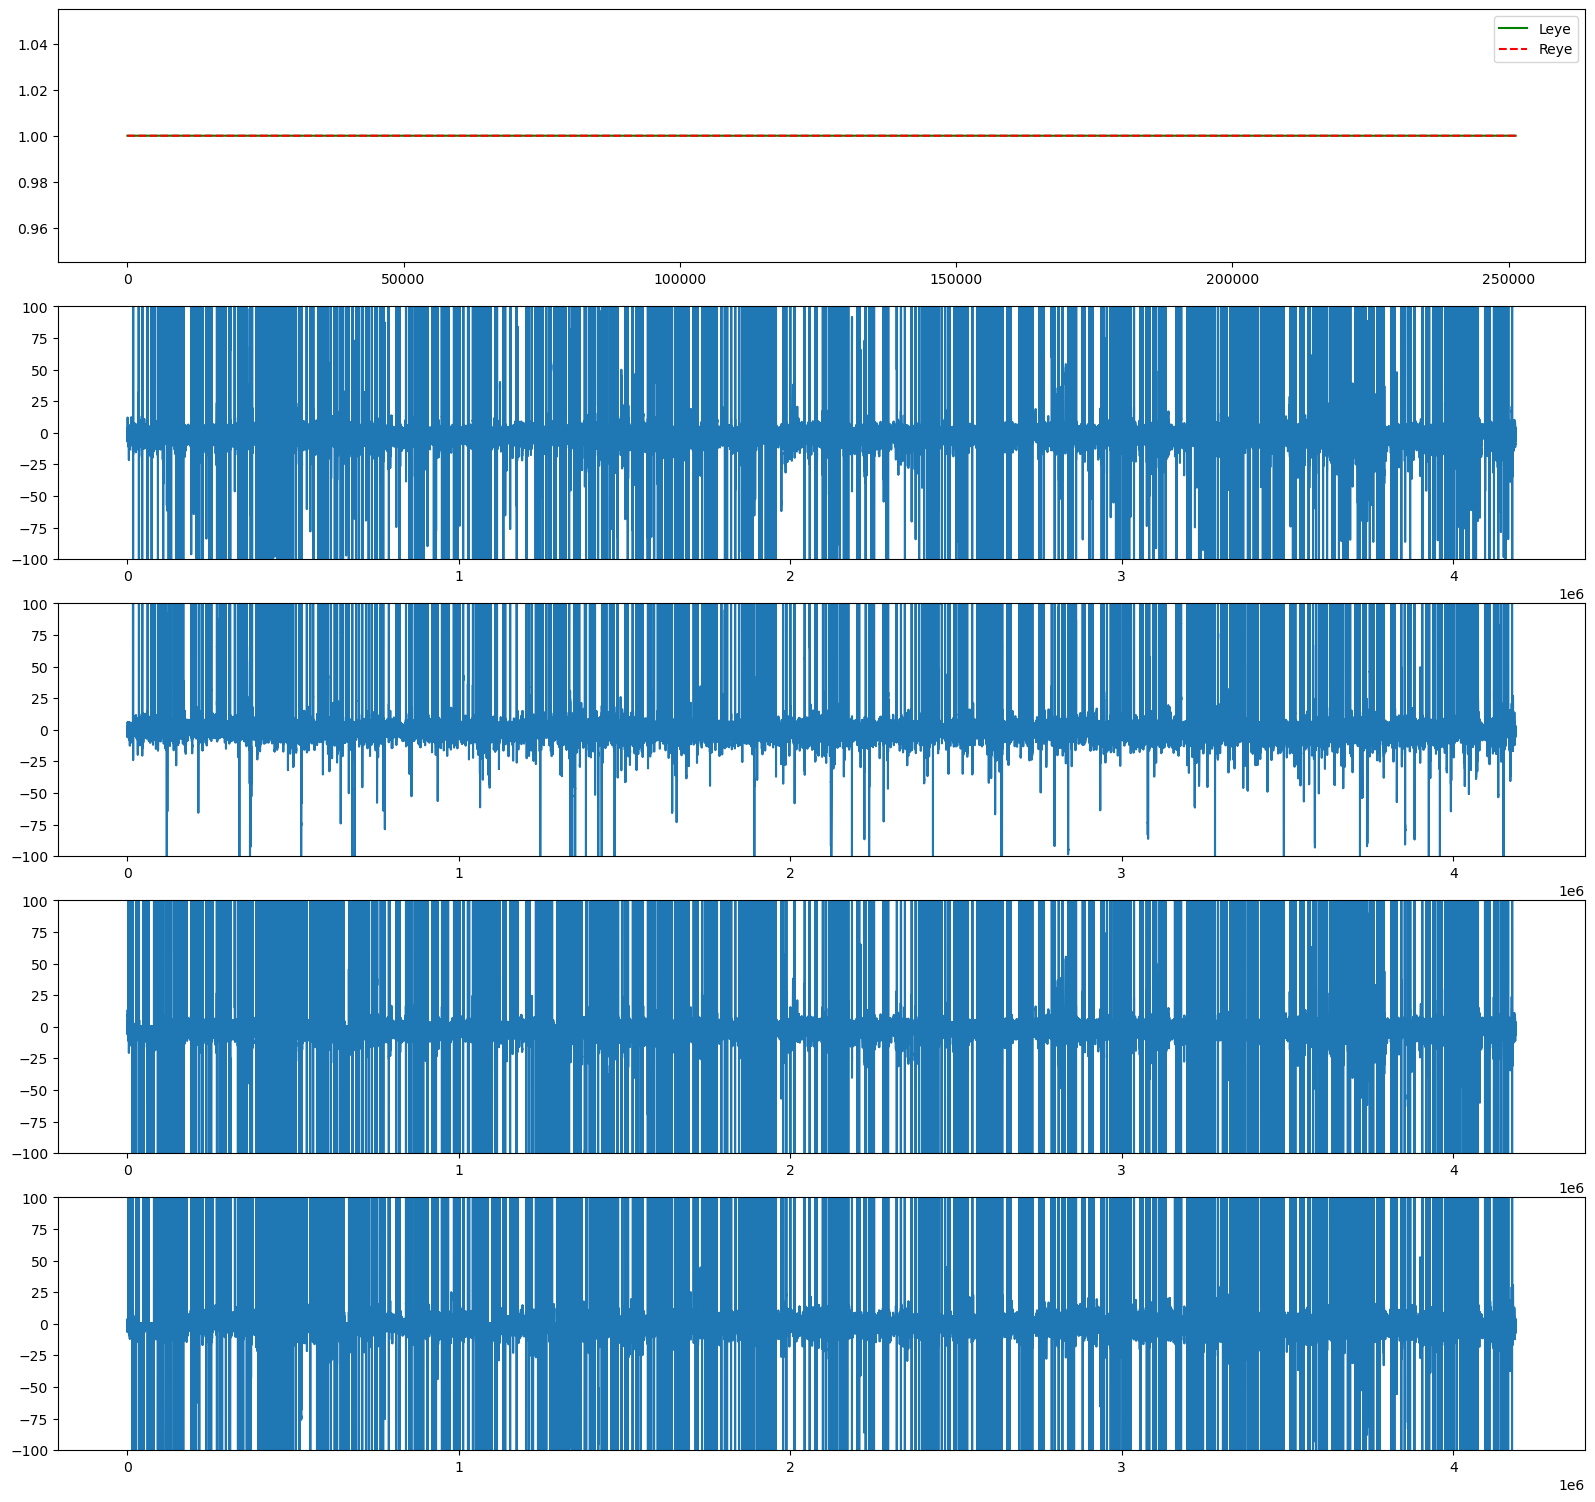

In [119]:
# plot raw eye traces to see how data validity looks
utils.ss(5,1)
plt.subplot(5,1,1)
plt.plot(useL,'g')
plt.plot(useR,'r--')
plt.legend(['Leye', 'Reye'])
for ii in range(4):
    plt.subplot(5,1,ii+2)
    plt.plot(ETraw[:,ii])
    plt.ylim([-100,100])
plt.show()

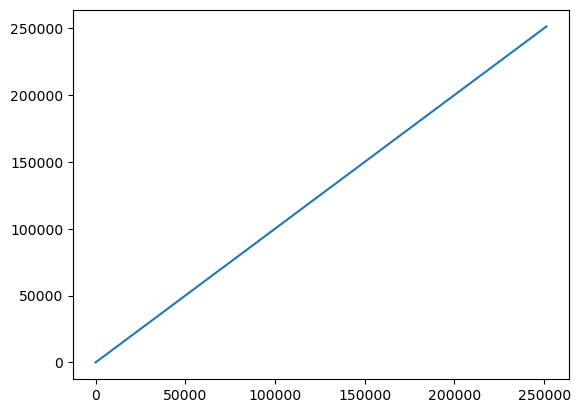

In [7]:
plt.plot(np.where((useL > 0) & (useR > 0))[0])

In [10]:
tB = np.where((useL > 0) & (useR > 0))[0]
tBhr = range(tB[0]//6*100, (tB[-1]+1)//6*100)

Mean-subtraction on dim 0: offset = 15.2
Mean-subtraction on dim 1: offset = 19.0
Mean-subtraction on dim 2: offset = 21.3
Mean-subtraction on dim 3: offset = 15.9
Mean-subtraction on dim 4: offset = 658.4


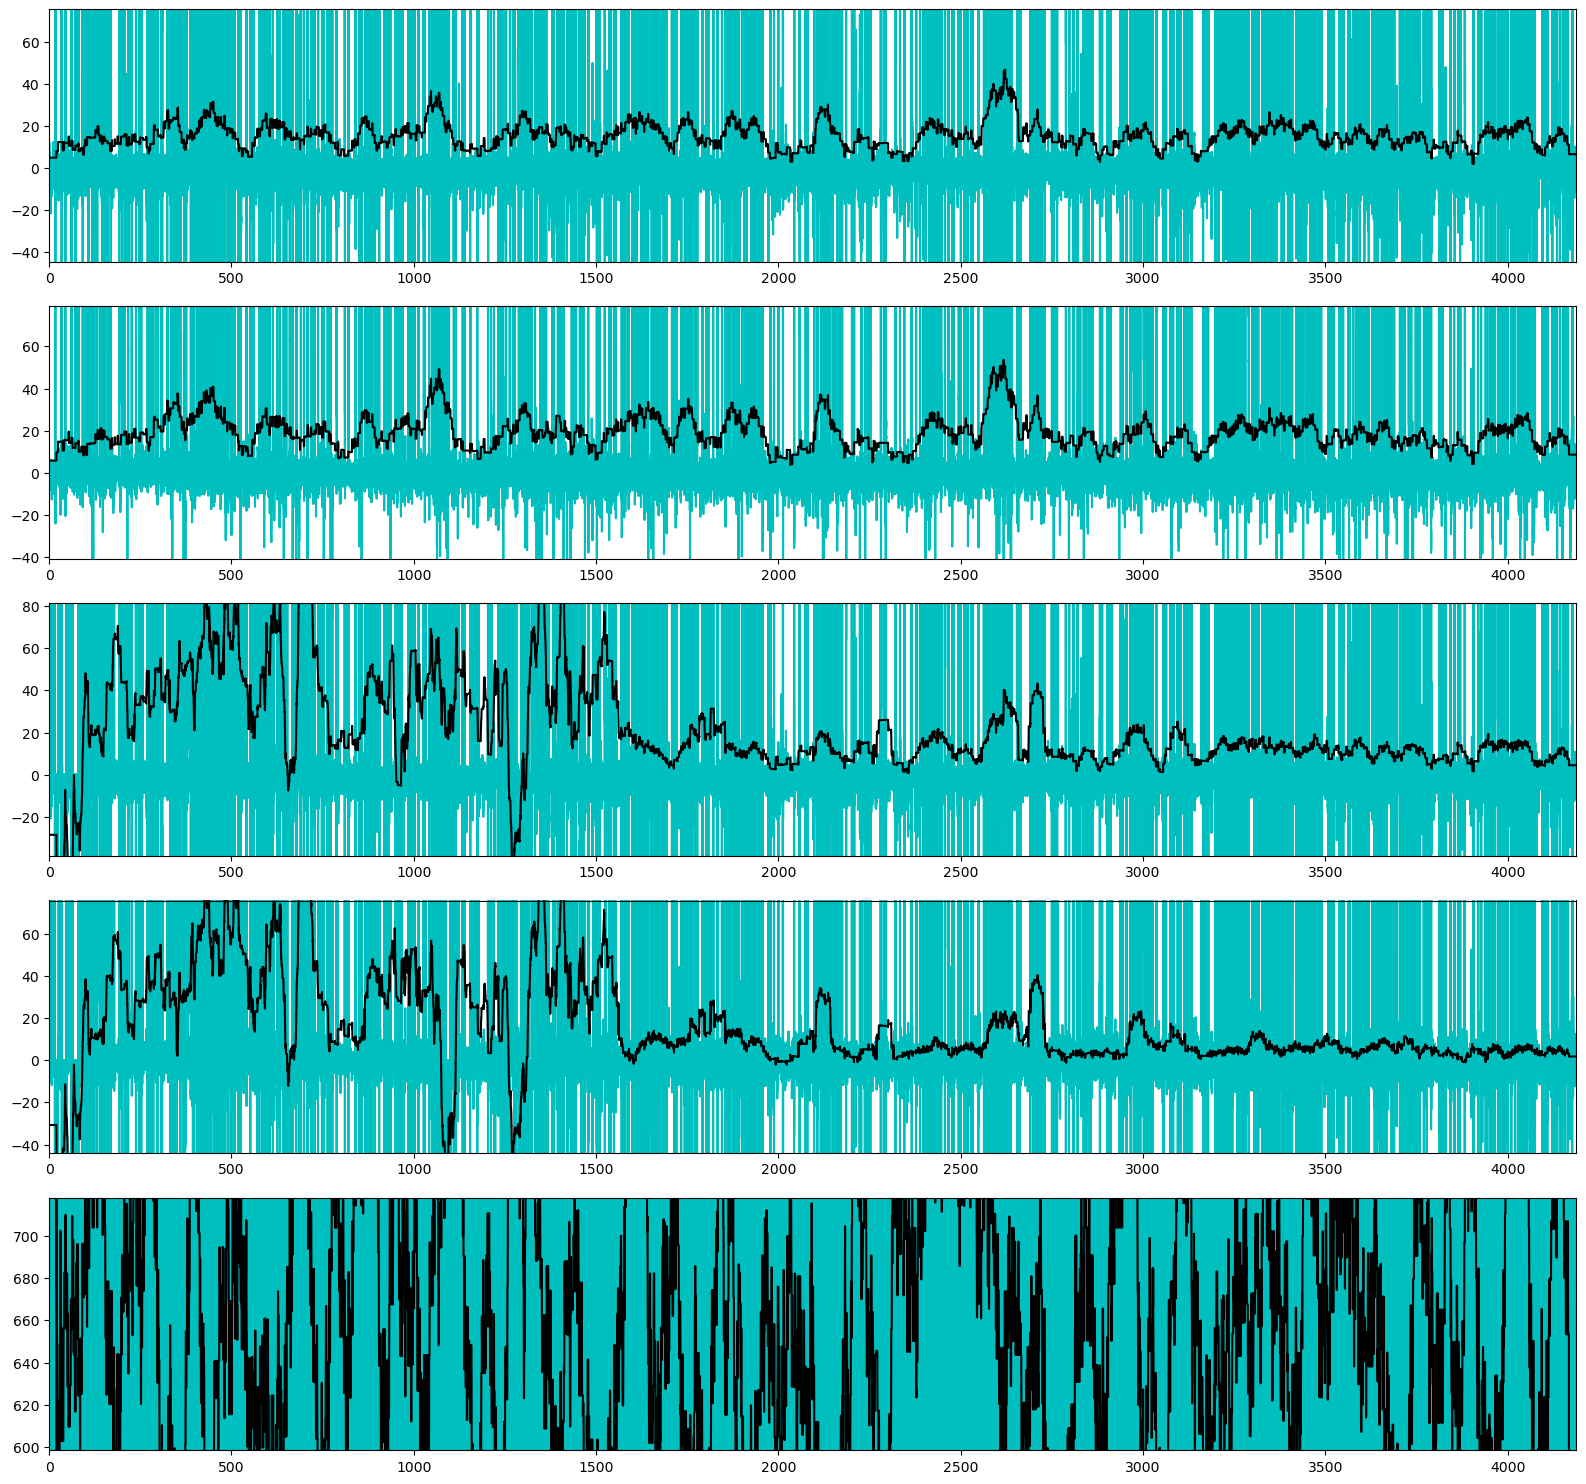

In [19]:
# calculate drift correction - adjust tau as needed to best capture ET drift
et1khzB1 = CU.slow_drift_correct( ETraw[tBhr, :], tau=40000 )

## Binocular processing

  3051 blinks detected and zeroed


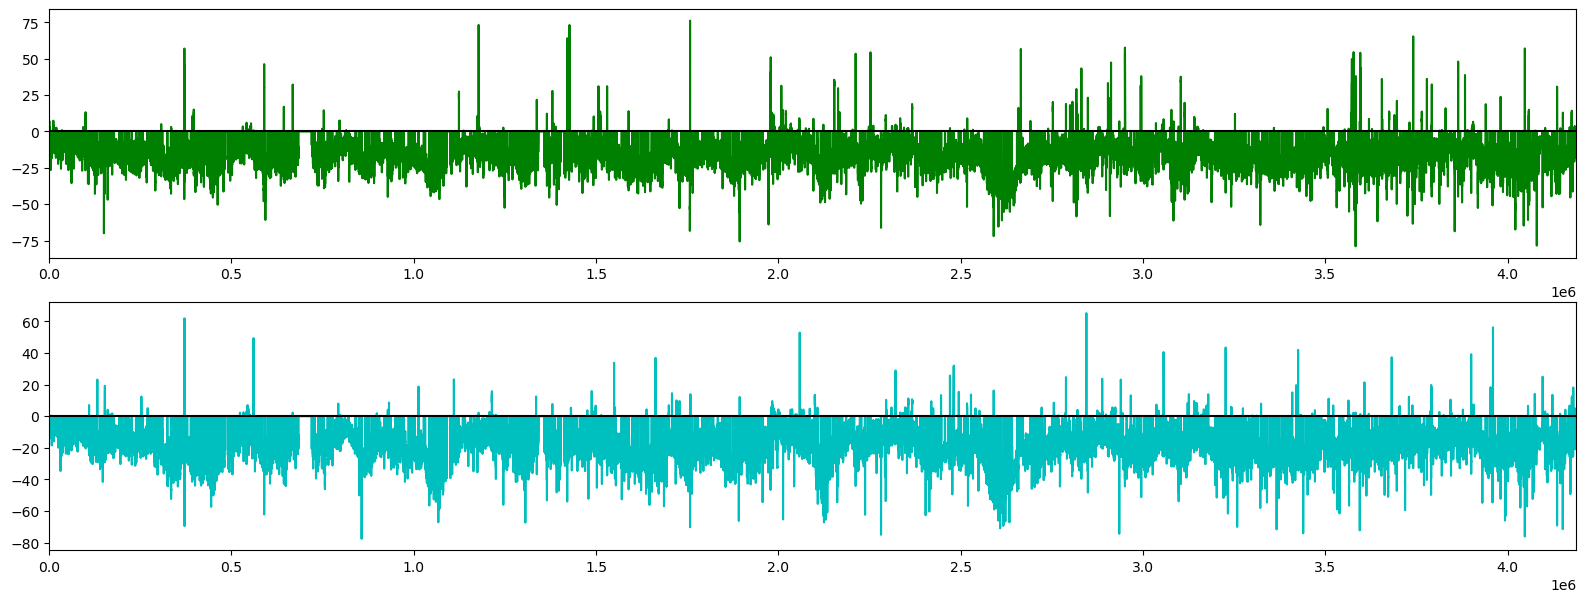

In [24]:
et1khzB, blinksB = CU.blink_process(et1khzB1, blink_thresh=80)

utils.ss(2,1)
plt.subplot(211)
plt.plot(et1khzB[:,0],'g')
plt.plot([0,et1khzB.shape[0]],[0,0],'k')
plt.xlim([0, et1khzB.shape[0]])
plt.subplot(212)
plt.plot(et1khzB[:,1],'c')
plt.plot([0,et1khzB.shape[0]],[0,0],'k')
plt.xlim([0, et1khzB.shape[0]])
plt.show()

In [25]:
# List of all potential saccade times
CsacsB, CampsB = CU.saccade_detect( et1khzB, blinks=blinksB )

Potential blink trial 0
Potential blink trial 1
Potential blink trial 2
Potential blink trial 3
Potential blink trial 4
Potential blink trial 5
Potential blink trial 6
Potential blink trial 7
Potential blink trial 8
Potential blink trial 9
Potential blink trial 10
Potential blink trial 11
Potential blink trial 12
Potential blink trial 13
Potential blink trial 14
Potential blink trial 15
Potential blink trial 16
Potential blink trial 17
Potential blink trial 18
Potential blink trial 19
Potential blink trial 20
Potential blink trial 21
Potential blink trial 22
Potential blink trial 23
Potential blink trial 24
Potential blink trial 25
Potential blink trial 26
Potential blink trial 27
Potential blink trial 28
Potential blink trial 29
Potential blink trial 30
Potential blink trial 31
Potential blink trial 32
Potential blink trial 33
Potential blink trial 34
Potential blink trial 35
Potential blink trial 36
Potential blink trial 37
Potential blink trial 38
Potential blink trial 39
Potential 

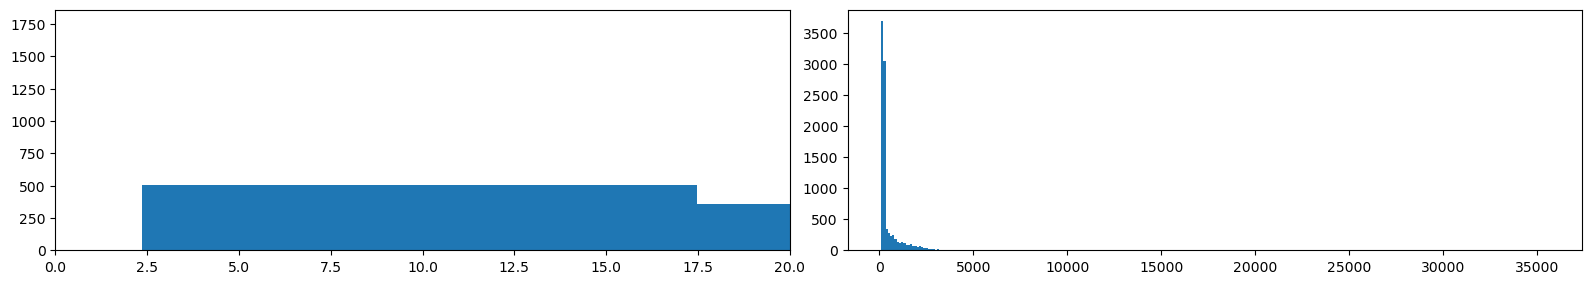

451.39  709.07


In [26]:
utils.ss(1,2)
plt.subplot(121)
a = plt.hist(np.sqrt(CampsB), bins=300)
plt.xlim([0, 20])
plt.subplot(122)
# Intersaccade interval distribution
plt.hist(np.diff(CsacsB), bins=300)

plt.show()
print("%0.2f  %0.2f"%(np.mean(np.diff(CsacsB)), np.std(np.diff(CsacsB))))

Amplitudes: [  38.24245  561.1237   565.2685   567.446    281.43747  278.00964
 4277.8506  4009.4165   378.4454 ]


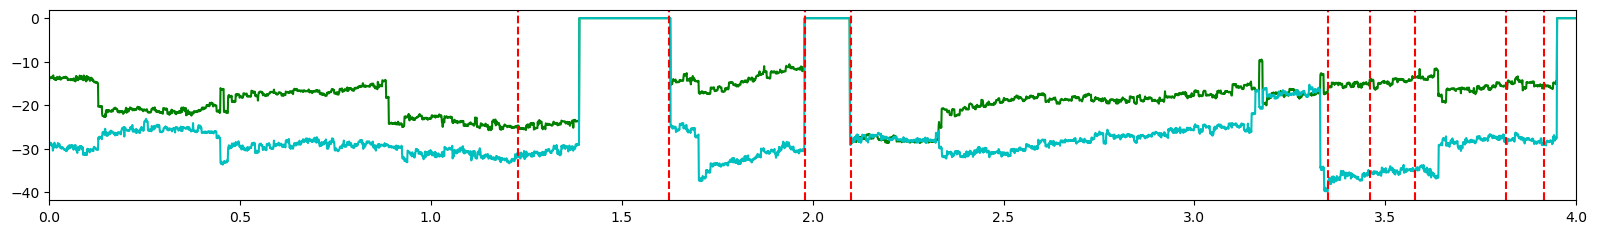

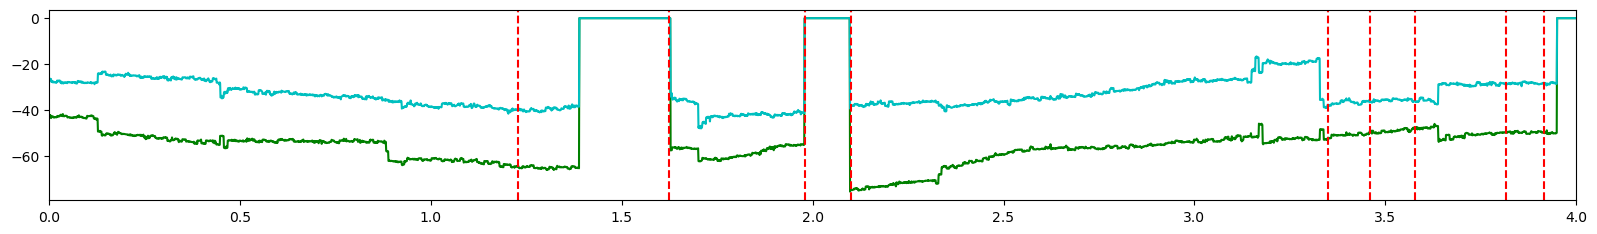

In [27]:
CU.trial_saccade_display(89, et1khzB, CsacsB, CampsB )

Amplitudes: [ 699.40936  750.76056  708.61     751.52234  722.6104   744.8171
  756.8924   281.09558 3988.5967   613.60754]


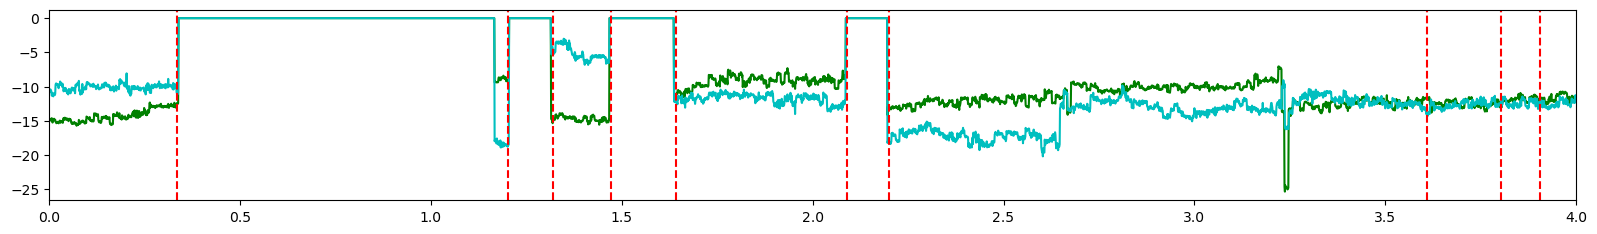

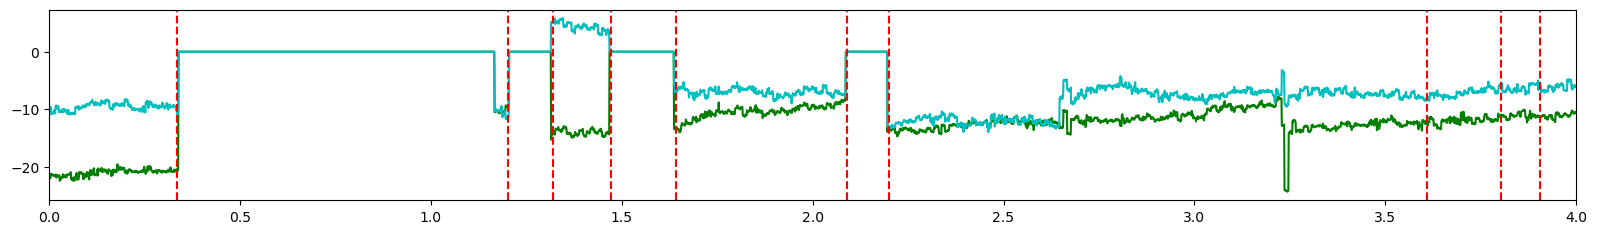

In [28]:
CU.trial_saccade_display(210, et1khzB, CsacsB, CampsB )

Amplitudes: [  32.936085  763.6221     32.936085  228.8428   3621.872    2184.7354
 4161.129     243.90154   190.73106 ]


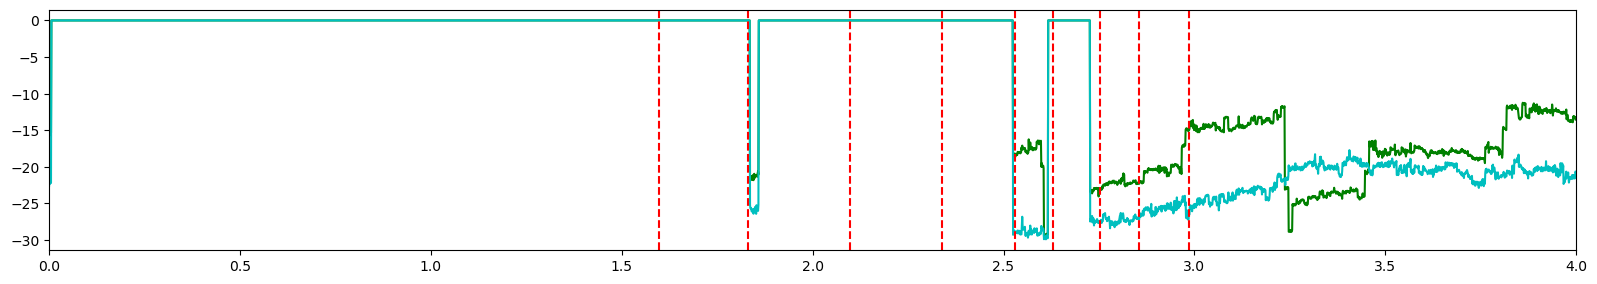

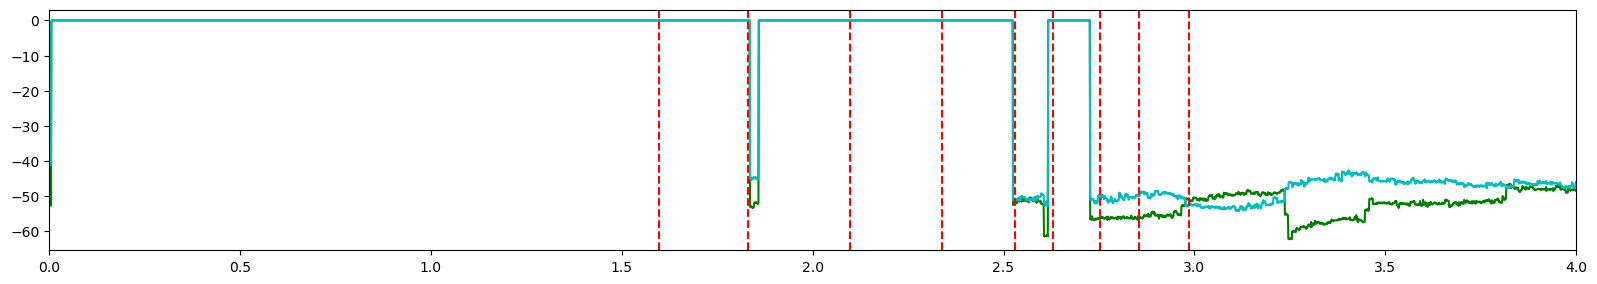

In [29]:
figgy = CU.trial_saccade_display(221, et1khzB, CsacsB, CampsB, fighandle=True, rh=3 )

In [21]:
#from NDNT.utils.DanUtils import figure_export
#figure_export( figgy[1], 'EyeLink_0722example222V.pdf' )
#figure_export( figgy[0], 'EyeLink_0722example222H.pdf' )

### Binocular segment process

In [18]:
ETtrace.shape, len(tB), len(tBhr)

((251280, 2), 251280, 4188000)

In [30]:
# Downsample to 120 Hz
ETprocB = np.zeros([len(tB), 4])
Ntr = et1khzB.shape[0]//4000
ts = np.arange(4000)
newts = np.arange(240)
for tr in range(Ntr):
    for dd in range(4):
        ETprocB[tr*240+newts, dd] = np.interp( newts/60, ts/1000, et1khzB[tr*4000+ts, dd] )

In [31]:
## Make amplitude threshold -- lets go up to 1.5 Hz
threshB = 6 #7.9  # 6 -> 0.1 deg
a = np.where(np.sqrt(CampsB) > threshB)[0]

Bsac_ts = CsacsB[a]  # time [bin] in ms

#sac_ts = deepcopy(CsacsB)  # integer times in ms
Bsacbins_all = np.floor(deepcopy(CsacsB)/1000*60).astype(int)  
Bsac_bins = Bsacbins_all[a] # Time [bin] in 60 Hz
Bsac_amps = CampsB[a]  # Amplistude
print("%d / %d saccades saved. %0.2f Hz"%(len(a), len(CampsB), len(a)*1000/len(tBhr)))

9231 / 9277 saccades saved. 2.20 Hz


In [32]:
print(np.min(Bsac_bins), np.max(Bsac_bins))

10 251238


In [33]:
sac_bins_all = deepcopy(Bsac_bins)

len(sac_bins_all), np.max(sac_bins_all),

(9231, 251238)

In [35]:
NT = ETprocB.shape[0]
ETproc_all = np.zeros( [NT,4], dtype=np.float32 )
ETproc_all[tB, :] = ETprocB

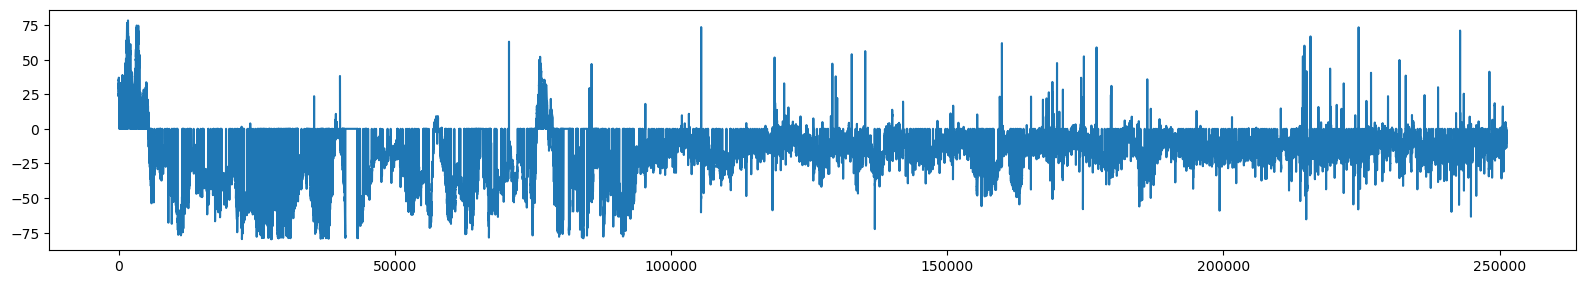

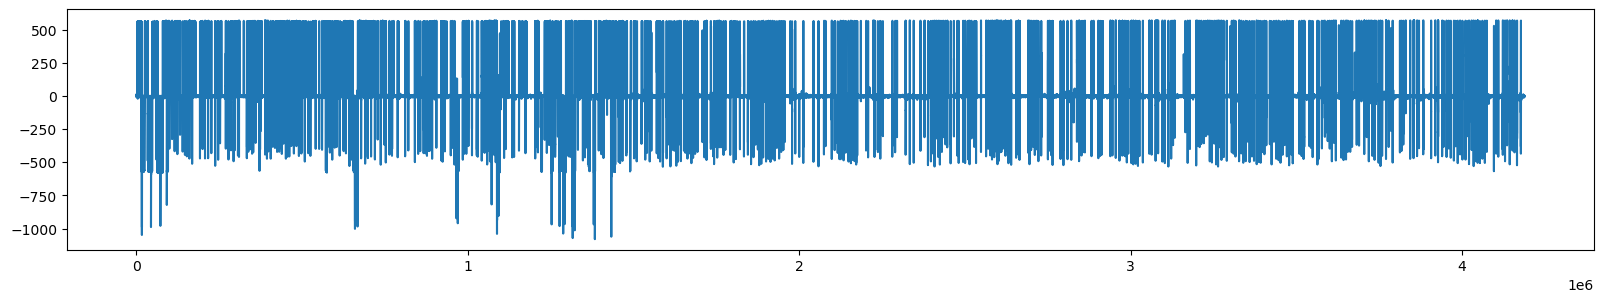

In [36]:
utils.ss()
plt.plot(ETproc_all[:,2])
plt.show()
utils.ss()
plt.plot(ETraw[:,2])
plt.show()

In [37]:
####### EXPORT ########
# sac_ts  ## microsaccade times in seconds (4 sec trials)
# sacbins # bin numbers of sac sampled at 60 Hz
# sac_amps ## squared magnitude
# Rsac_amps, Rsac_ts # reduced sac times & amplitude given threshold
# ETproc # downsampled processed eye trace
# et1khz # full sized et trace (1 kHz sample) -- processed

sio.savemat( datadir2+fn+'_ETupdate.mat', {
    'ALLsac_bins': sac_bins_all,  ## microsaccade times in seconds (4 sec trials)
    'et60Hz_all': ETproc_all, # bin numbers of sac sampled at 60 Hz

    'tsacs_msB': Bsac_ts,  ## microsaccade times in seconds (4 sec trials)
    'sac_bins_allB': Bsacbins_all, # bin numbers of sac sampled at 60 Hz
    'sac_amps_allB': CampsB, ## squared magnitude
    'sac_ampsB': Bsac_amps, # reduced sac times & amplitude given threshold
    'sac_binsB': Bsac_bins,
    'sac_tsB': Bsac_ts,
    'et60HzB': ETprocB, # downsampled processed eye trace
    'et1kHzB': et1khzB,

    'tsacs_msL': [],  ## microsaccade times in seconds (4 sec trials)
    'sac_bins_allL': [], # bin numbers of sac sampled at 60 Hz
    'sac_amps_allL': [], ## squared magnitude
    'sac_ampsL': [], # reduced sac times & amplitude given threshold
    'sac_binsL': [],
    'sac_tsL': [],
    'et60HzL': [], # downsampled processed eye trace
    'et1kHzL': [],

    'tsacs_msR': [],  ## microsaccade times in seconds (4 sec trials)
    'sac_bins_allR': [], # bin numbers of sac sampled at 60 Hz
    'sac_amps_allR': [], ## squared magnitude
    'sac_ampsR': [], # reduced sac times & amplitude given threshold
    'sac_binsR': [],
    'sac_tsR': [],
    'et60HzR': [], # downsampled processed eye trace
    'et1kHzR': []
} ) # full sized et trace (1 kHz sample) -- processed

# inocular dDPI

# Data filter preprocess

Note that firing rates will change dramatically with the monocular sections, so apply data-filtering separately to each

In [48]:
import NTdatasets.conway.multi_datasets as datasets

#num_lags = 10
inclMUs = True
data = datasets.MultiClouds(
    filenames=[fn0], datadir=datadir2, eye_config=3, drift_interval=16, 
    luminance_only=True, binocular=False, include_MUs=inclMUs)

NT = data.robs.shape[0]
print("%d (%d valid) time points"%(NT, len(data)))

NC = data.NC
print(NC,'cells')

#SUs_lam = np.where(data.channel_map < 64)[0]
#MUs_lam = np.where(data.channel_map < 64)[0]
#print('Laminar probe units: %d SUs, %d MUs'%(len(SUs_lam), len(MUs_lam)) )
#lam_units = np.where(data.channel_map < 32)[0]
#ETunits = np.where(data.channel_map > 32)[0]
#print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))
# default stimulus
data.assemble_stimulus(which_stim='et')
len(data.robs), len(tB)

  FILE_INFO: stim_locsLP list again -- ok but output check
  MULTIDATASET 1 expts: 251280 total time steps, 76 units
251280 (251280 valid) time points
76 cells
SensoryBase: assemble_stimulus not implemented in class child.


(251280, 251280)

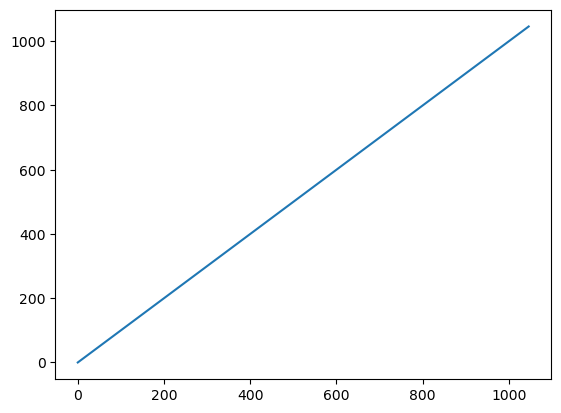

In [51]:
Btr = range((tB[-1]+1)//240)
plt.plot(Btr)

In [65]:
ts

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [99]:
np.sum(data.dfs[ts]*data.robs[ts],axis=0)

array([  0,   3,   2,   4,   1,  16,  15,  14,  24, 141,   0,   0,  25,
         1,  80,   2,   9,  72,  49,   4,  12,  29,  24,   6,   0,   5,
        22,   1,  32,  15,  12,  11, 138,  21,  37,  10,   8,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        19,  16,   8,  60,   0,   0,   2,  17,   0,   0,  16,  48,   9,
        12,  18,  12,   6,   3,  10,   1,  24,  48,  15,   2],
      dtype=uint64)

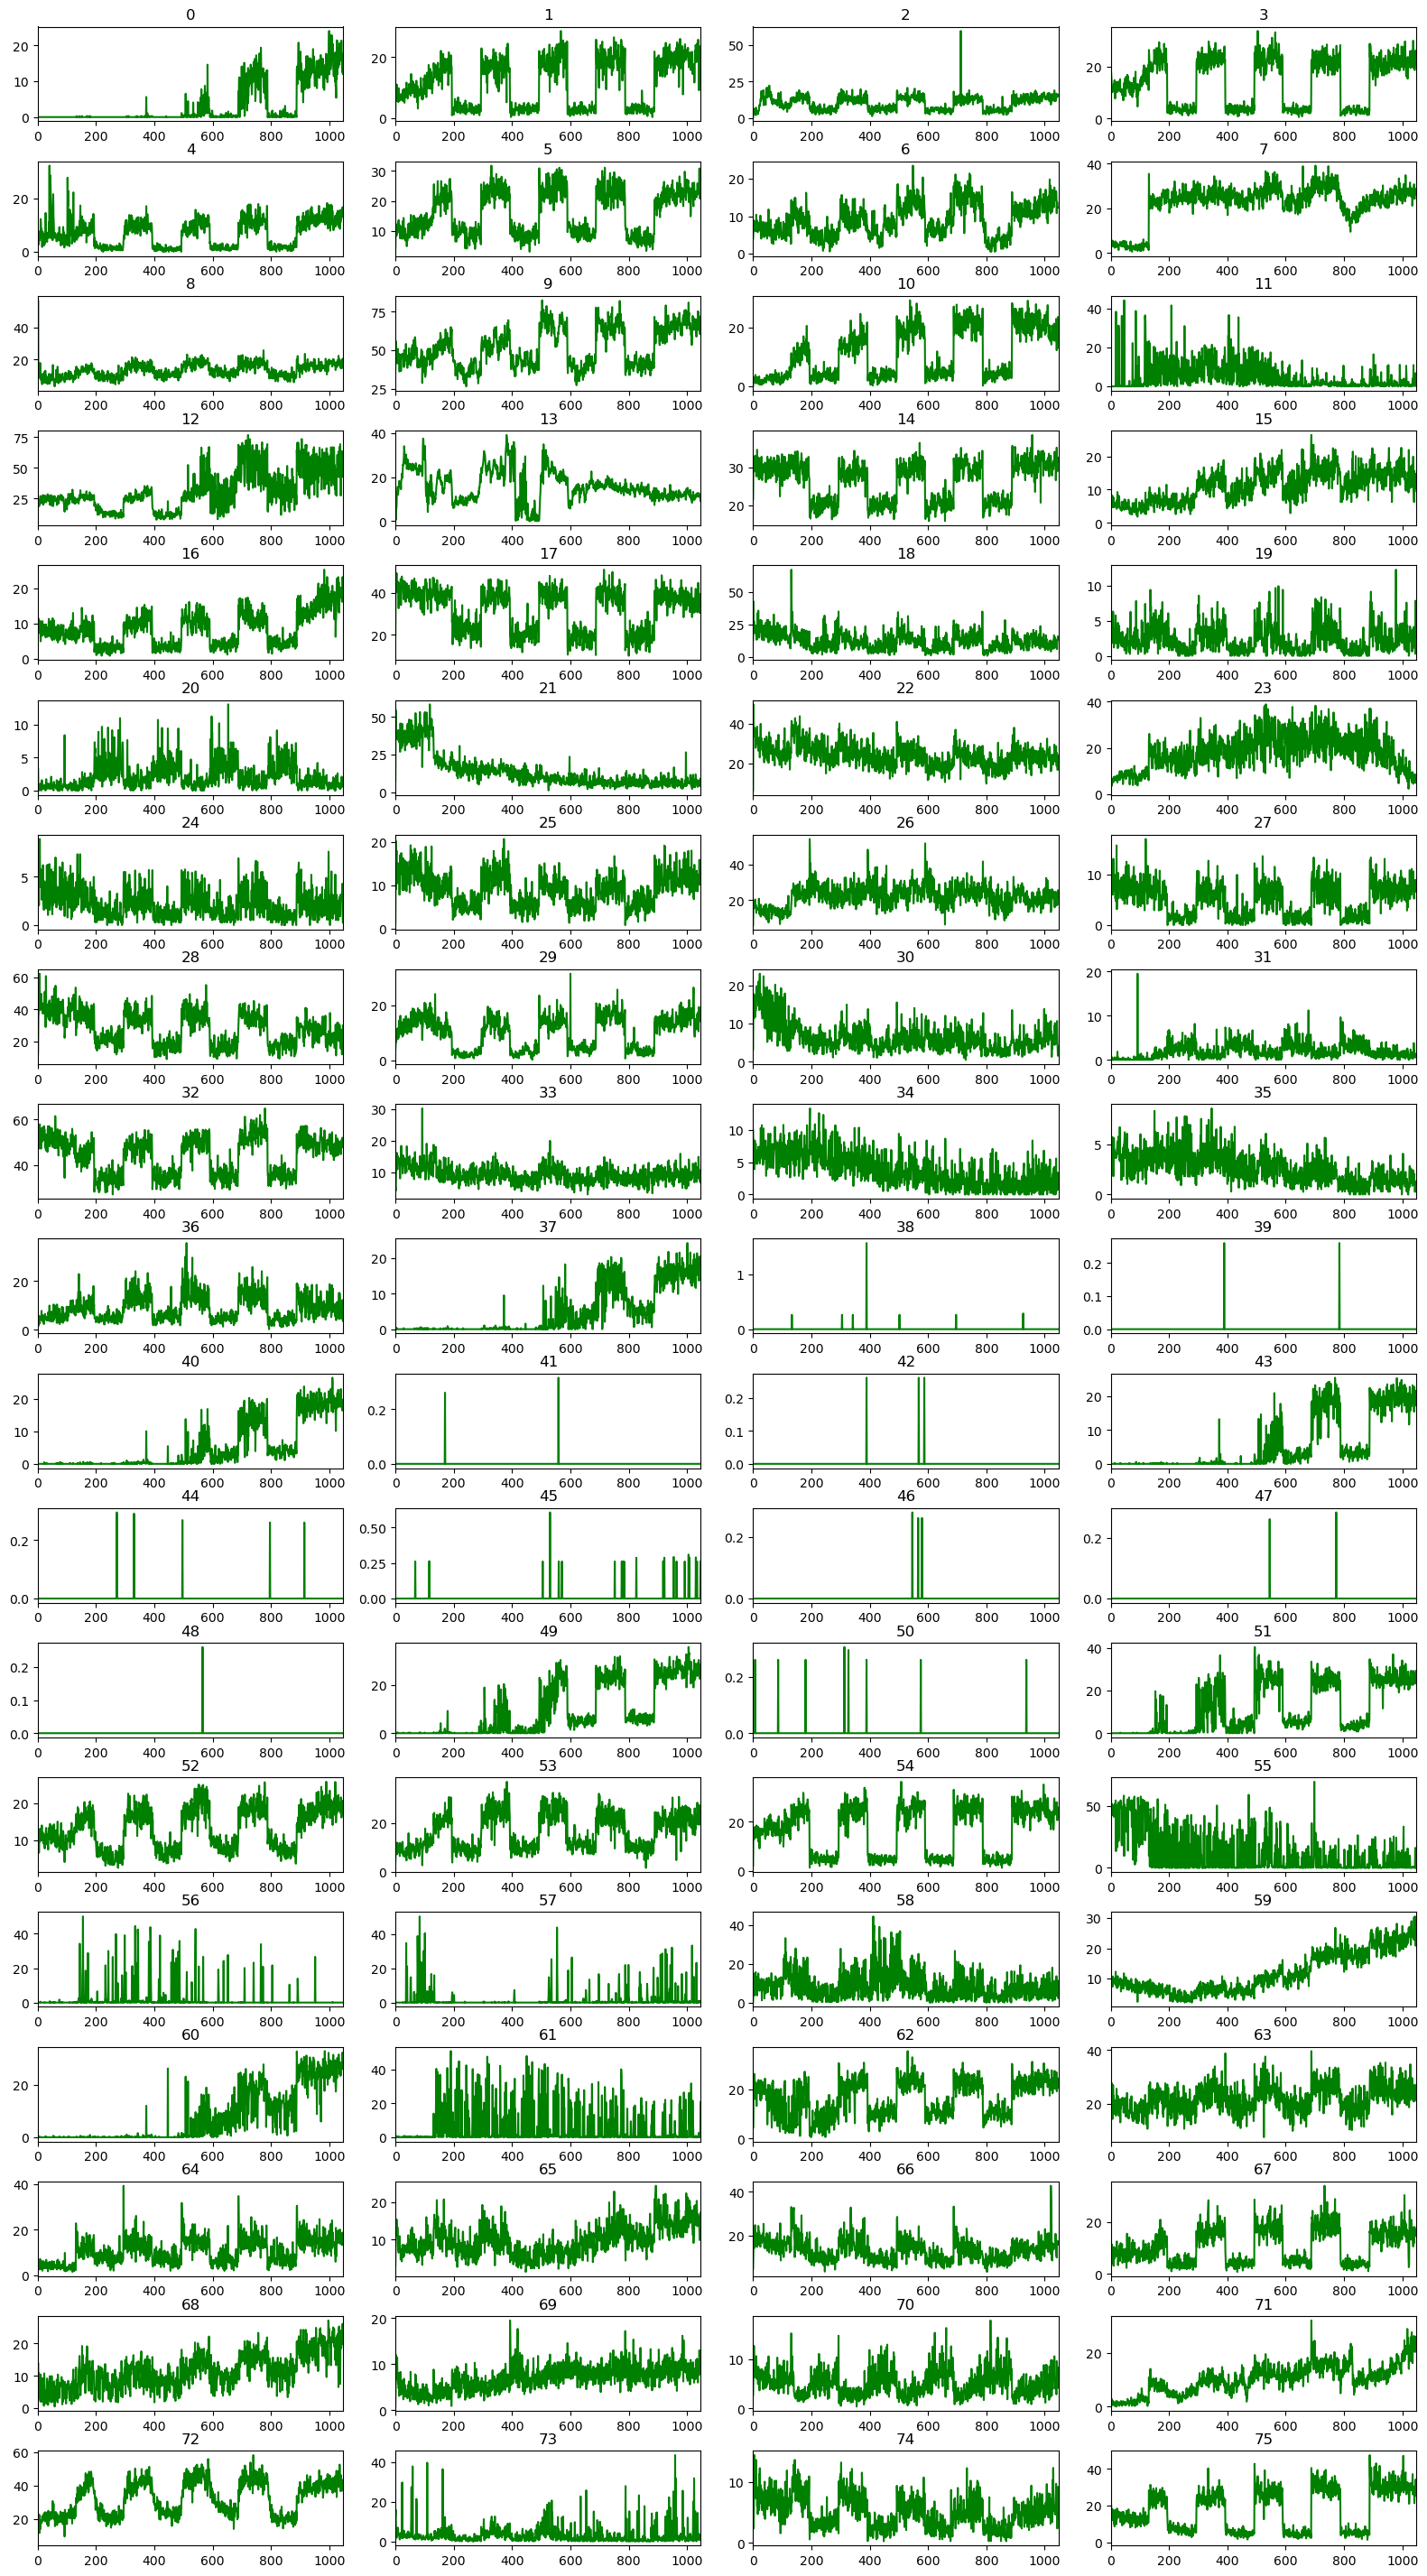

In [103]:
# Firing rate profiles and pruning
BLsize = 240
# data.cells_out = list(ETunits)  #already done earlier
NB = data.NT//BLsize
Ntrack = np.zeros([NB, NC])
for bb in range(NB):
    ts = np.arange(BLsize*bb, BLsize*(bb+1))
    Ntrack[bb, :] = 60*(np.sum(
        data.dfs[ts]*data.robs[ts],axis=0)/np.sum(data.dfs[ts],axis=0))

nrows = int(np.ceil(NC/4))
utils.ss(nrows, 4, row_height=1.5)
for cc in range(NC):
    plt.subplot(nrows,4, cc+1)
    plt.plot(Ntrack[:,cc],'g')
    #plt.plot([0,NB],[0,0],'k')
    ys = plt.ylim()
    plt.xlim([0, NB])
    plt.ylim(ys)
    plt.title("%d"%(cc))
plt.show()

### Binocular DFs

In [104]:
#val_units = []
DFtrial = np.zeros([NB, NC])
NB, len(Btr)

(1047, 1047)

  Removing hole size=97
  Stability criteria not met: 0.4459745762711864


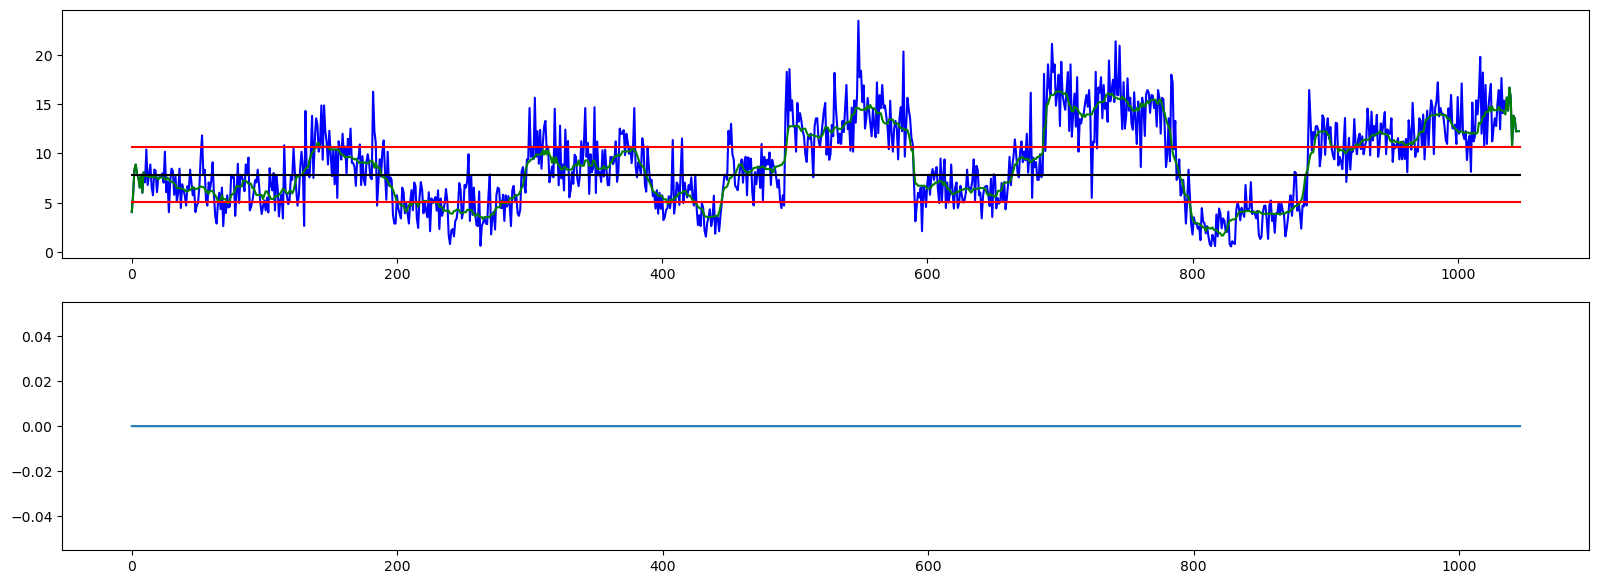

In [106]:
test = CU.firingrate_datafilter( Ntrack[Btr, 6], frac_reject=0.2, FRcut=2, verbose=True, to_plot=True )

/home/conwaylab/anaconda3/envs/torch38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/conwaylab/anaconda3/envs/torch38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


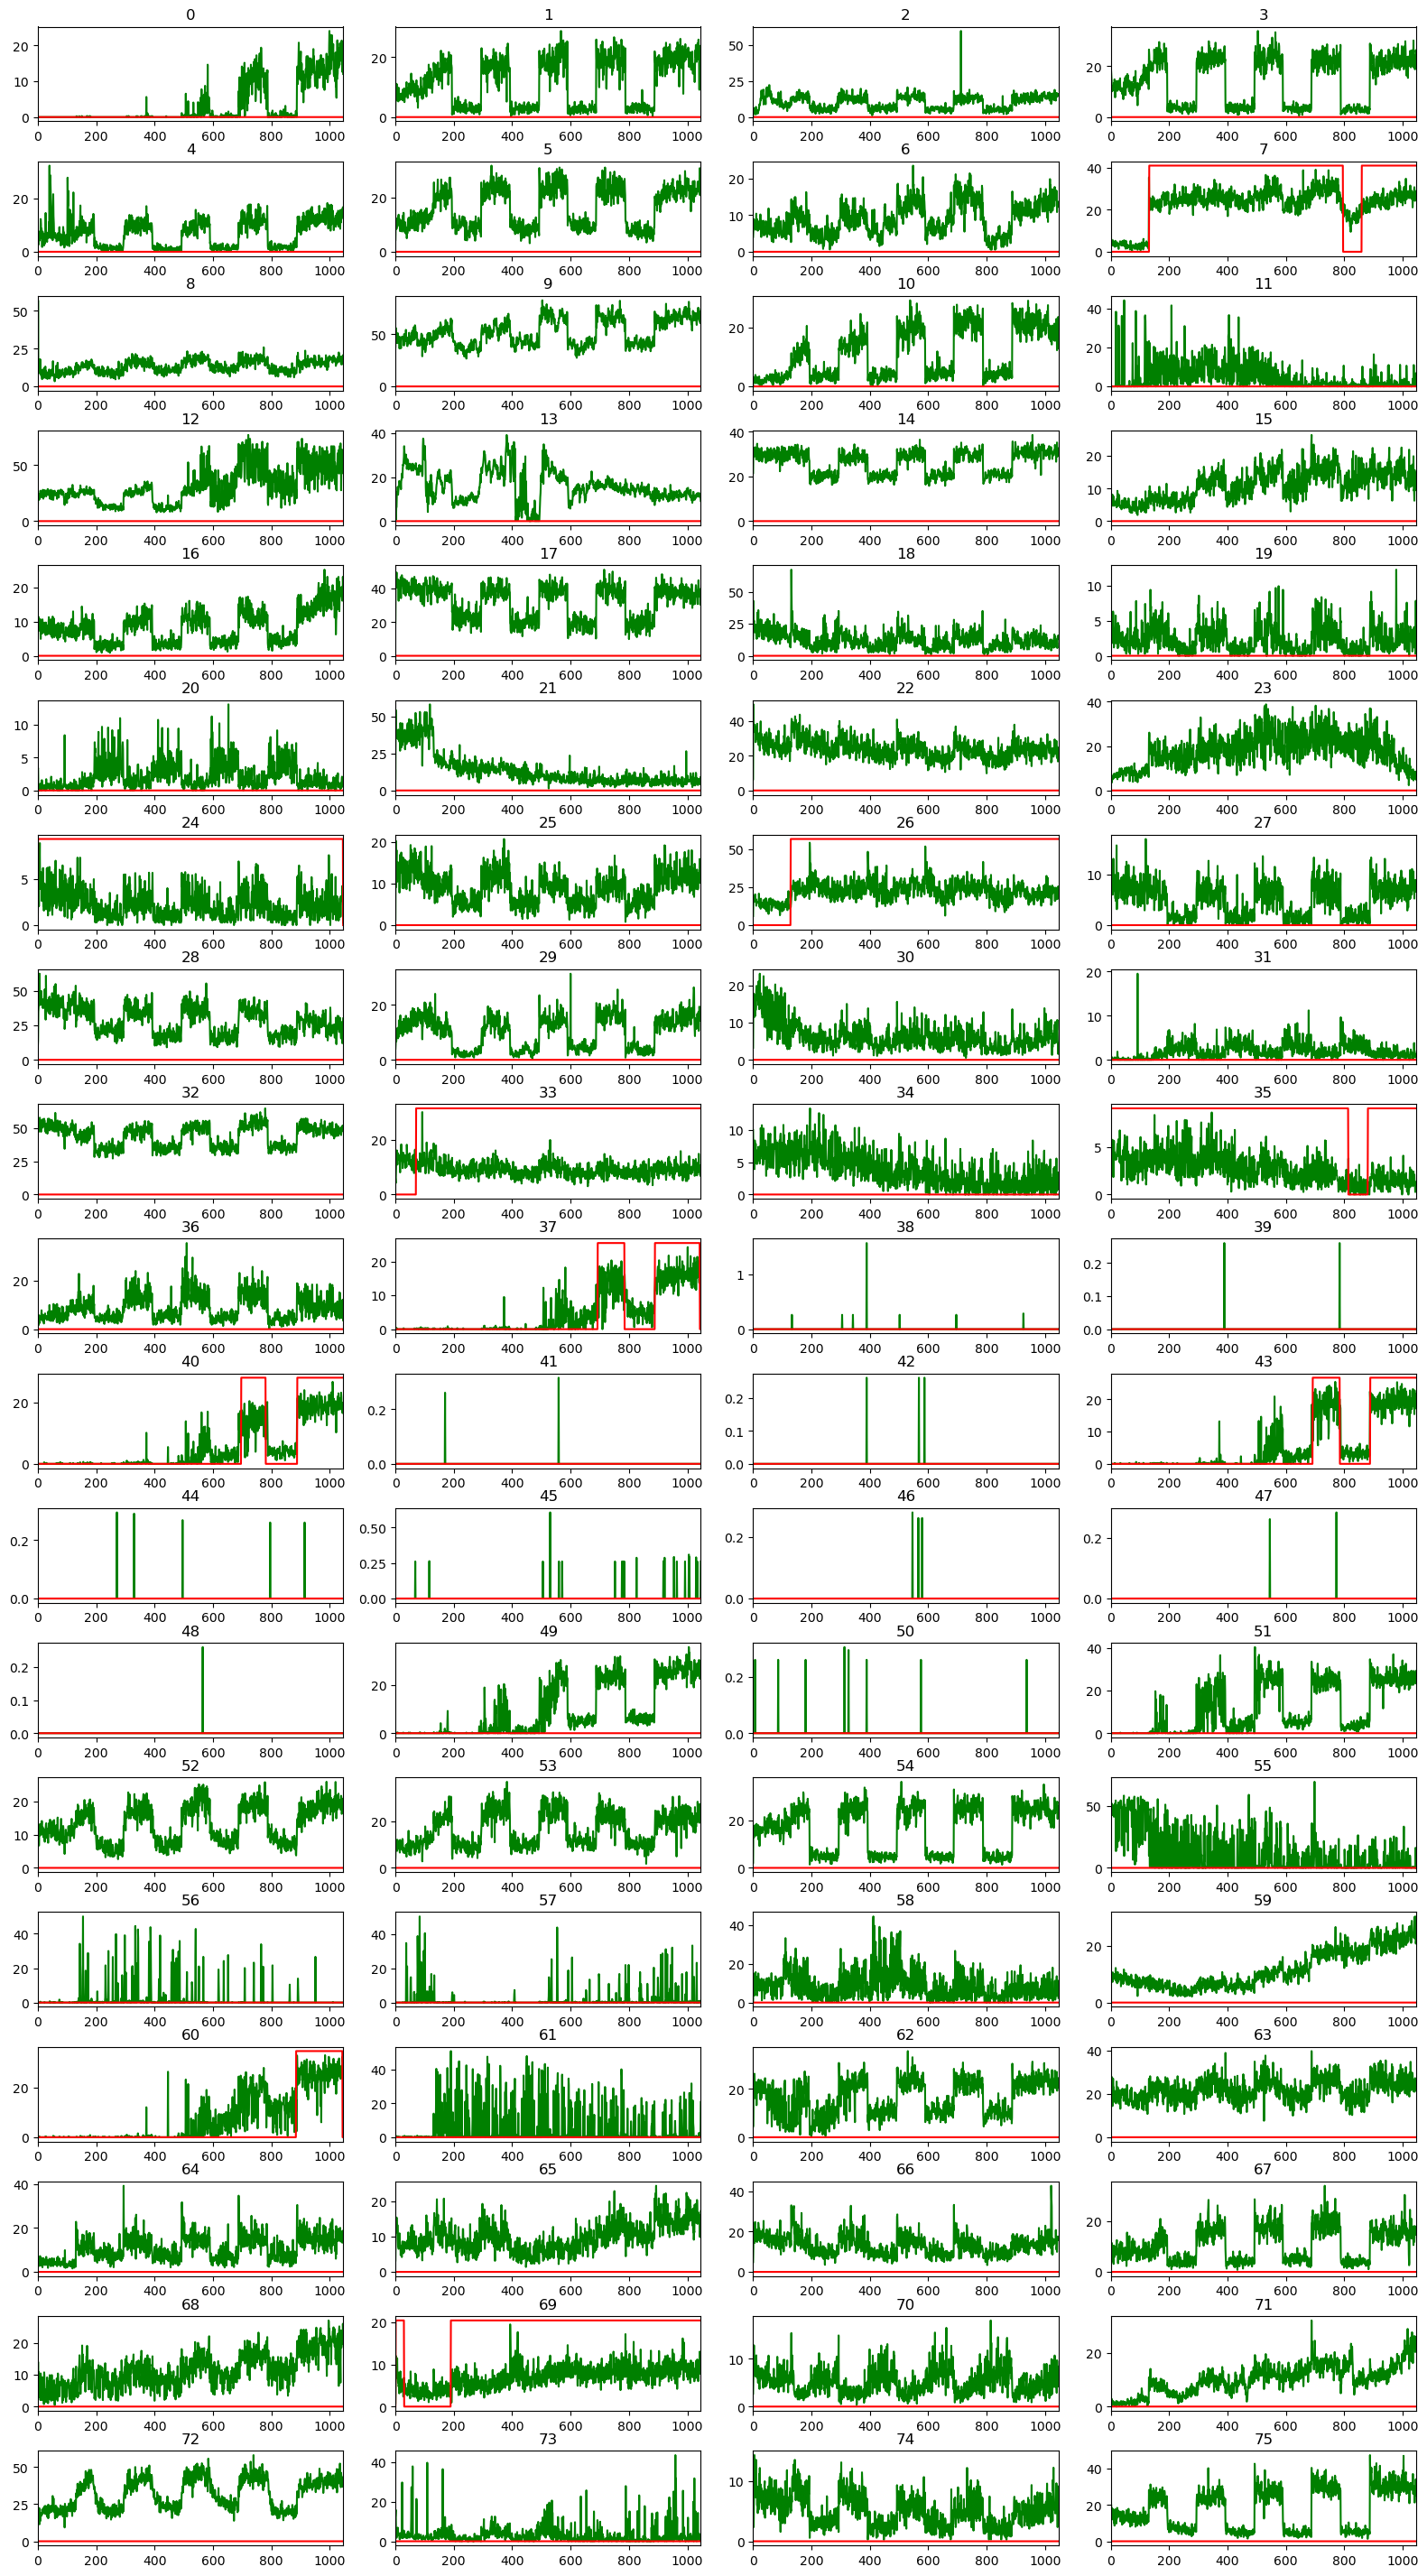

In [107]:
# Go through all units and eliminate or get trial-level data_filter
utils.ss(nrows, 4, row_height=1.5)
for cc in range(NC):
    #print(cc)
    DFtrial[Btr, cc] = CU.firingrate_datafilter( Ntrack[Btr, cc], frac_reject=0.1, FRcut=2.0, verbose=False )
    plt.subplot(nrows,4, cc+1)
    plt.plot(Ntrack[Btr,cc],'g')
    ys = plt.ylim()
    plt.plot(DFtrial[Btr, cc]*ys[1], 'r' )
    plt.xlim([0, Btr[-1]])
    #if np.sum(DFtrial[:, cc]) > 0:
    #    val_units.append(cc)
    plt.title("%d"%(cc))
plt.show()

#utils.imagesc(DFtrial[Btr,:])

In [112]:
# Modifications
DFtrial[Btr, 1] = 1
DFtrial[Btr, 2] = 1
DFtrial[Btr, 3] = 1
DFtrial[Btr[200:], 4] = 1
DFtrial[Btr, 5] = 1
DFtrial[Btr, 6] = 1
DFtrial[Btr[200:], 7] = 1
DFtrial[Btr, 8] = 1
DFtrial[Btr, 9] = 1
DFtrial[Btr, 10] = 1
DFtrial[Btr, 14] = 1
DFtrial[Btr, 16] = 1
DFtrial[Btr, 17] = 1
DFtrial[Btr, 18] = 1
DFtrial[Btr[150:], 21] = 1
DFtrial[Btr, 22] = 1
DFtrial[Btr, 25] = 1
DFtrial[Btr, 27] = 1
DFtrial[Btr, 28] = 1
DFtrial[Btr, 29] = 1
DFtrial[Btr[200:], 30] = 1
DFtrial[Btr, 32] = 1
DFtrial[Btr, 36] = 1

DFtrial[Btr[500:], 51] = 1
DFtrial[Btr, 52] = 1
DFtrial[Btr, 53] = 1
DFtrial[Btr, 54] = 1
DFtrial[Btr, 62] = 1
DFtrial[Btr, 63] = 1
DFtrial[Btr, 64] = 1
DFtrial[Btr, 65] = 1
DFtrial[Btr, 66] = 1
DFtrial[Btr, 67] = 1
DFtrial[Btr, 68] = 1
DFtrial[Btr, 68] = 1
DFtrial[Btr, 69] = 1
DFtrial[Btr, 70] = 1
DFtrial[Btr, 72] = 1
DFtrial[Btr, 74] = 1
DFtrial[Btr, 75] = 1


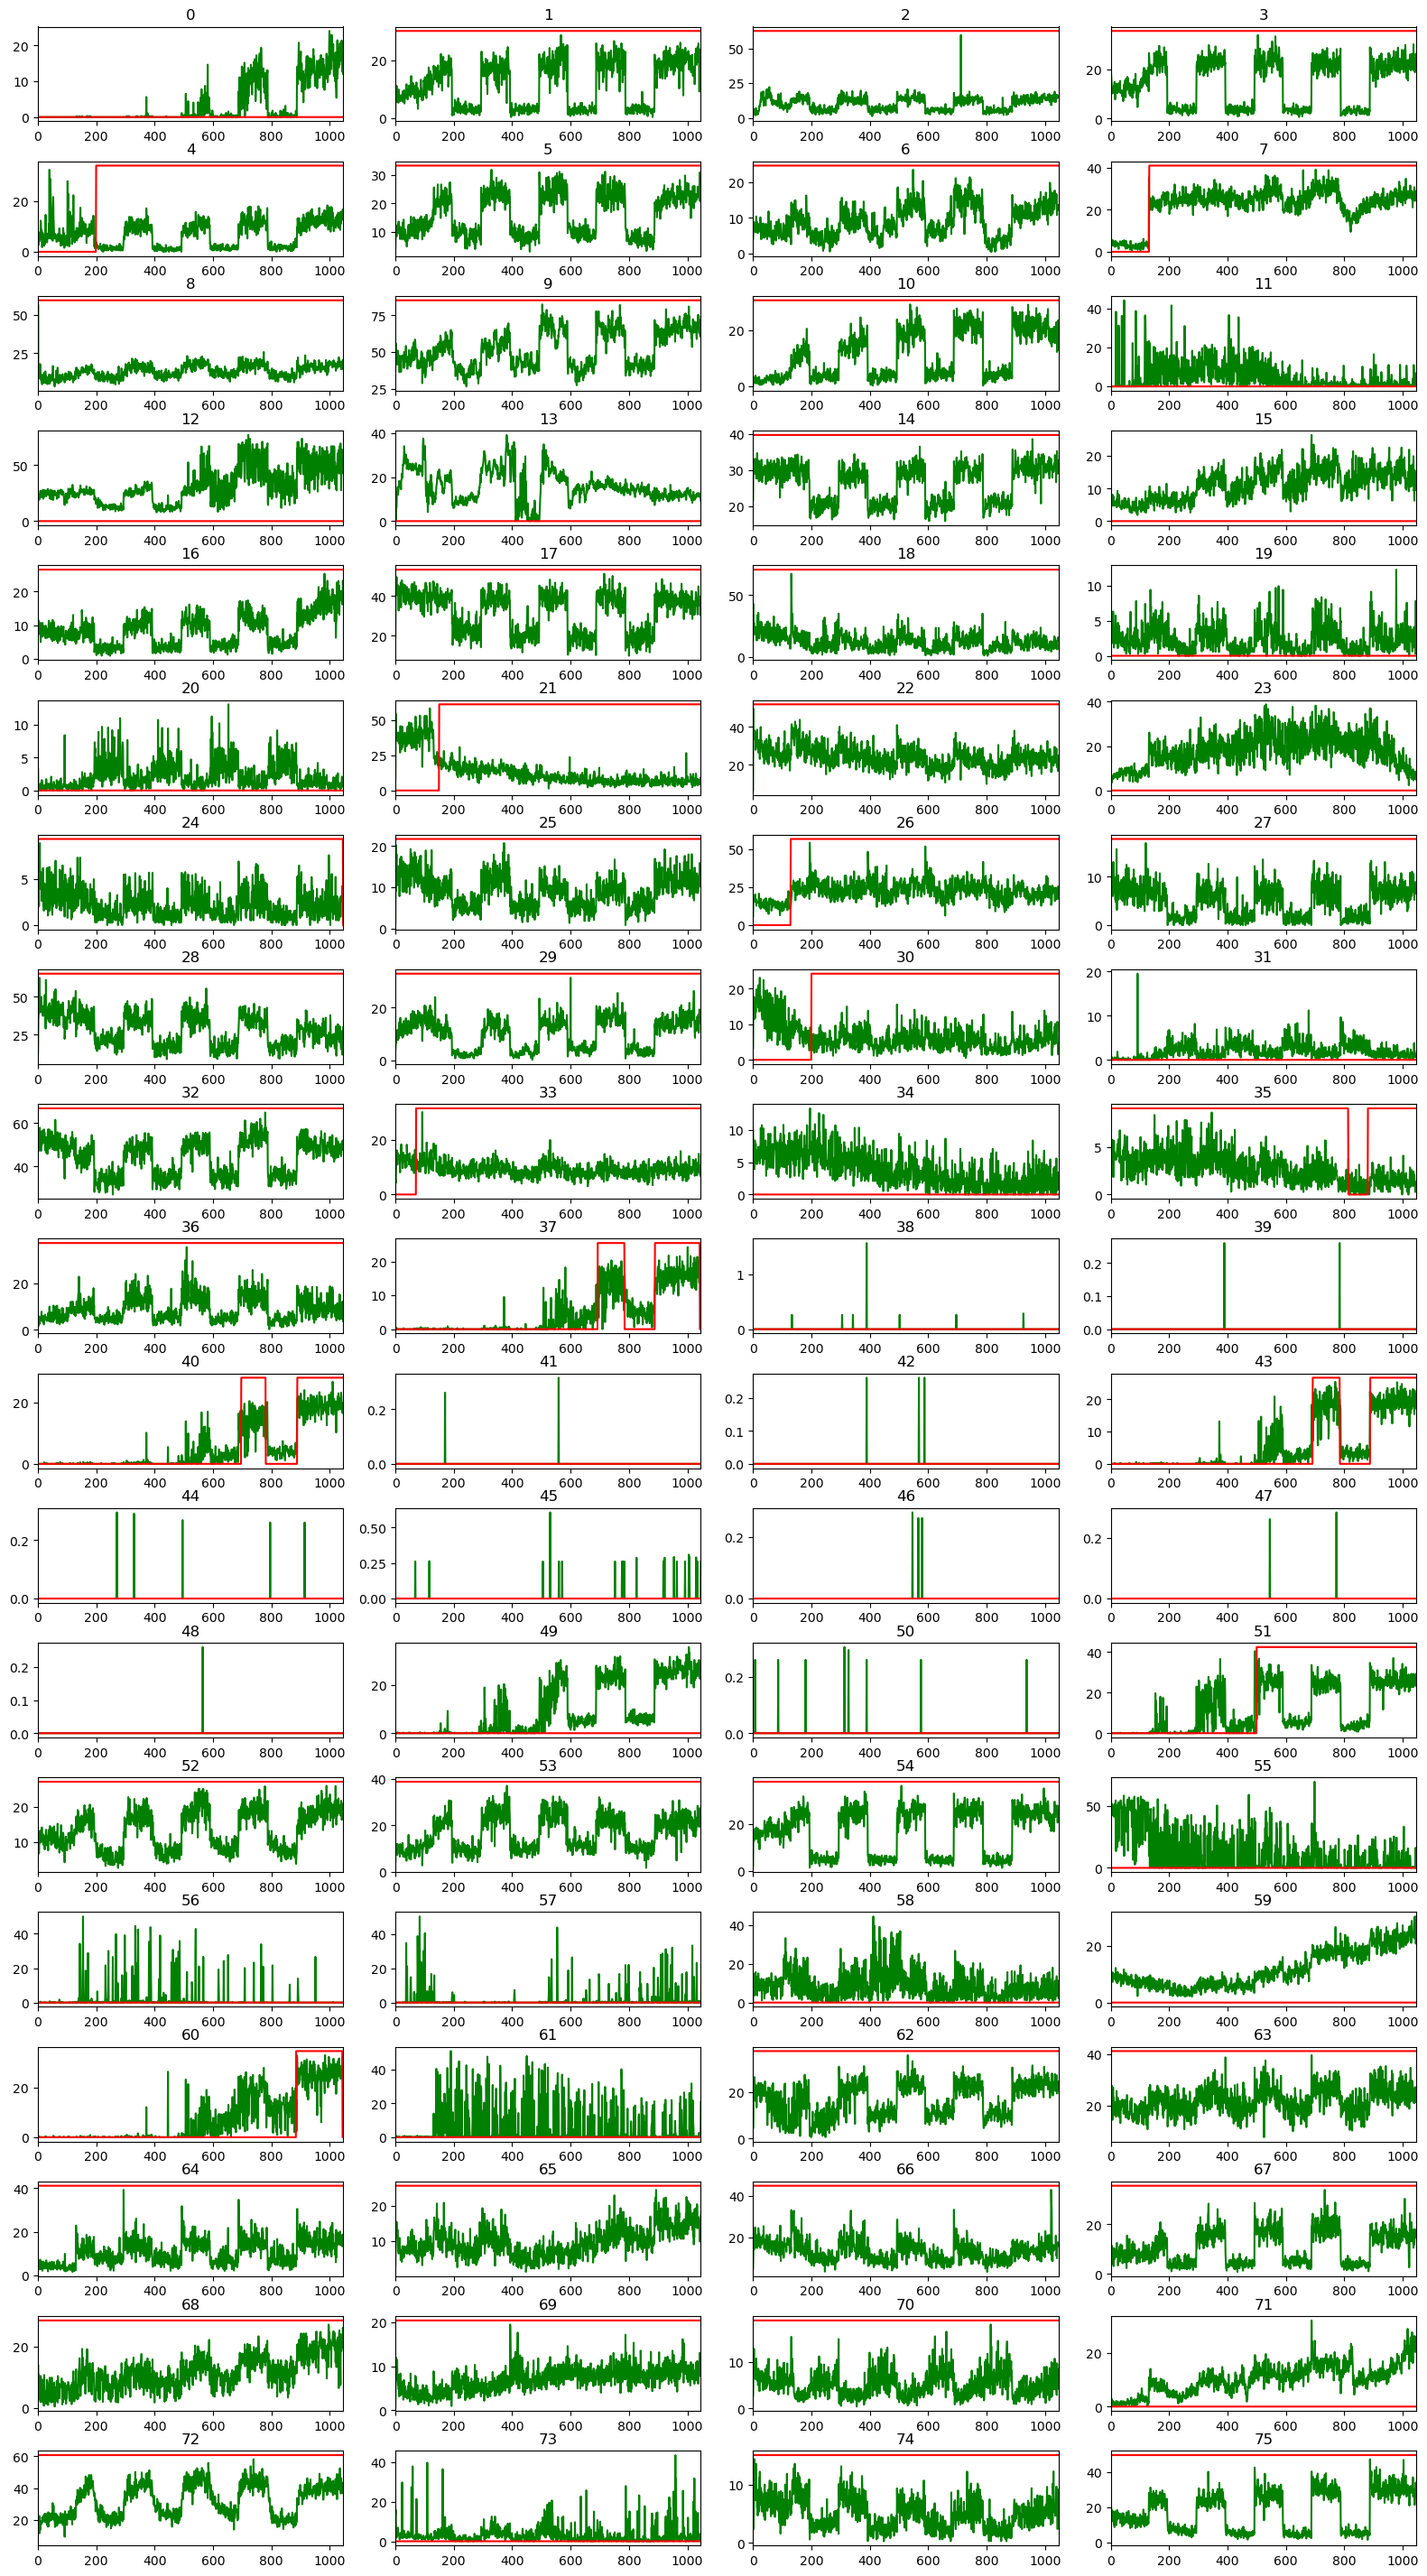

In [113]:
utils.ss(nrows, 4, row_height=1.5)
for cc in range(NC):
    #print(cc)
    plt.subplot(nrows,4, cc+1)
    plt.plot(Ntrack[Btr,cc],'g')
    ys = plt.ylim()
    plt.plot(DFtrial[Btr, cc]*ys[1], 'r' )
    plt.xlim([0, Btr[-1]])
    #if np.sum(DFtrial[:, cc]) > 0:
    #    val_units.append(cc)
    plt.title("%d"%(cc))
plt.show()

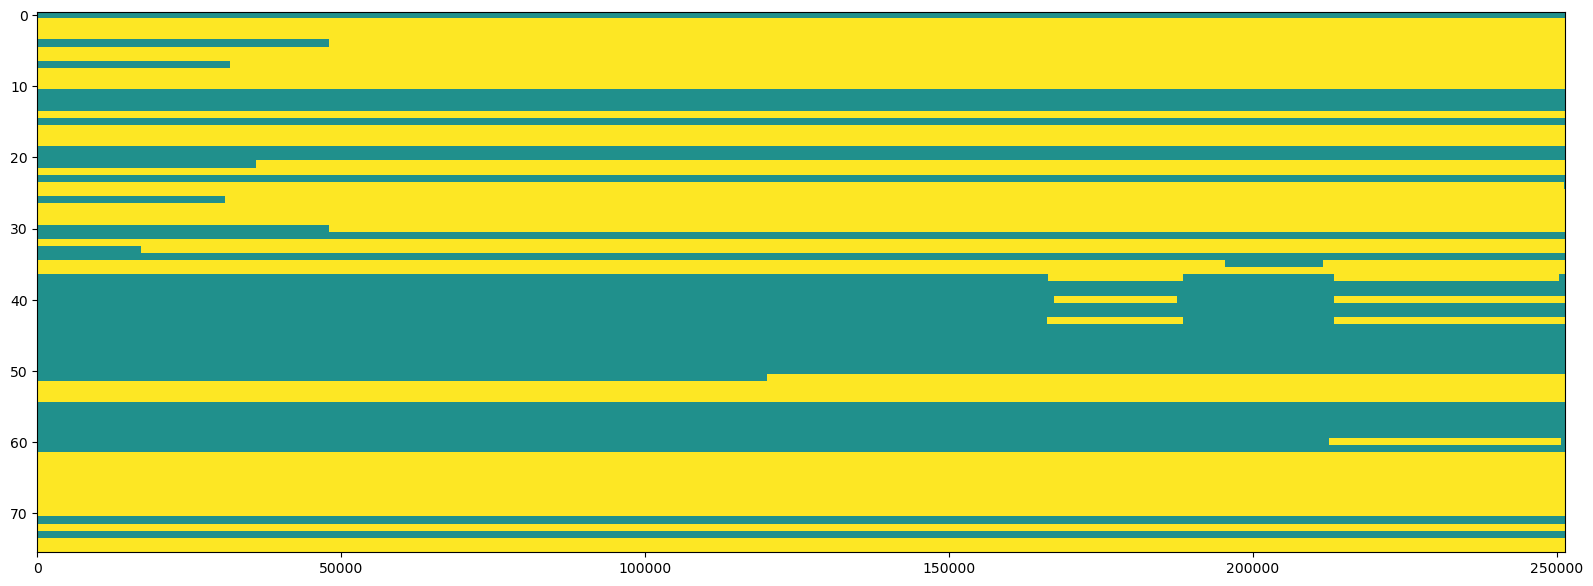

In [116]:
XDF = CU.DFexpand( DFtrial, data.NT )
utils.ss(row_height=6)
utils.imagesc(XDF)

In [118]:
sio.savemat(datadir2+fn+'_DFupdate.mat', {'XDF': XDF})